In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn')
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from scipy.interpolate import LSQUnivariateSpline

In [2]:
df = pd.read_csv("data/strongdrink.txt")
df.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
df["cultivar"].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

a. Multinomial logistic regression

In [4]:
y = df["cultivar"]
X = df[["alco","malic","tot_phen","color_int"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=20)

In [5]:
clf = LogisticRegression(solver='newton-cg',multi_class='multinomial').fit(X_train, y_train)

In [6]:
pd.DataFrame({"j=1":np.append(clf.intercept_[0],clf.coef_[0]),
              "j=2":np.append(clf.intercept_[1],clf.coef_[1])},
               index=["beta0","beta1",'beta2','beta3','beta4'])

,j=1,j=2
beta0,-24.011332,22.801680
beta1,1.700433,-1.467985
beta2,-0.265610,-0.333051
beta3,1.223894,0.664006
beta4,0.022748,-0.922709


In [7]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



The error rates are 13%, 0%, and 0% for group 1,2, and 3, respectively.

The model is best at predicting the third group (highest f1-score).

The one with the most observations is the second group. So the most accurately predicted category is not the one with the most observations.

b. LOOCV

In [8]:
Xvars = df[['alco', 'malic', 'tot_phen', 'color_int']].values
yvars = df['cultivar'].values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)
y_test_lst = np.zeros(N_loo)
y_pred_lst = np.zeros(N_loo)


In [9]:
for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    y_pred_lst[test_index] = y_pred
    y_test_lst[test_index] = y_test
    MSE_vec[test_index] = (y_test != y_pred)
    print('MSE for test set', test_index, ' is', MSE_vec[test_index])

MSE for test set [0]  is [0.]
MSE for test set [1]  is [0.]
MSE for test set [2]  is [0.]
MSE for test set [3]  is [0.]
MSE for test set [4]  is [0.]
MSE for test set [5]  is [0.]
MSE for test set [6]  is [0.]
MSE for test set [7]  is [0.]
MSE for test set [8]  is [0.]
MSE for test set [9]  is [0.]
MSE for test set [10]  is [0.]
MSE for test set [11]  is [1.]
MSE for test set [12]  is [0.]
MSE for test set [13]  is [0.]
MSE for test set [14]  is [0.]
MSE for test set [15]  is [0.]
MSE for test set [16]  is [0.]
MSE for test set [17]  is [0.]
MSE for test set [18]  is [0.]
MSE for test set [19]  is [0.]
MSE for test set [20]  is [0.]
MSE for test set [21]  is [1.]
MSE for test set [22]  is [1.]
MSE for test set [23]  is [1.]
MSE for test set [24]  is [1.]
MSE for test set [25]  is [1.]
MSE for test set [26]  is [0.]
MSE for test set [27]  is [1.]
MSE for test set [28]  is [0.]
MSE for test set [29]  is [0.]
MSE for test set [30]  is [0.]
MSE for test set [31]  is [0.]
MSE for test set [

In [10]:
print(classification_report(y_test_lst, y_pred_lst))

             precision    recall  f1-score   support

        1.0       0.84      0.78      0.81        59
        2.0       0.83      0.89      0.86        71
        3.0       0.96      0.93      0.95        46

avg / total       0.86      0.86      0.86       176



Error rate for each type is 0.16, 0.17, 0.04 respectively. The most precise estimation is j=3.

In [11]:
MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('Test estimate MSE loocv = {}.'.format(MSE_loo))

Test estimate MSE loocv = 0.13636363636363635.


(c)

In [12]:
X=df[["alco", "malic", "tot_phen", "color_int"]].values
y=df["cultivar"].values
k = 4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(X)

MSE_vec_kf = np.zeros(k)

k_ind = int(0)
for train_index, test_index in kf.split(X):
    print('k index=', k_ind)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    print(classification_report(y_test, y_pred))
    k_ind += 1

k index= 0
MSE for test set 0  is 0.1590909090909091
             precision    recall  f1-score   support

          1       0.71      1.00      0.83        12
          2       1.00      0.75      0.86        24
          3       0.78      0.88      0.82         8

avg / total       0.88      0.84      0.84        44

k index= 1
MSE for test set 1  is 0.11363636363636363
             precision    recall  f1-score   support

          1       1.00      0.76      0.87        17
          2       0.69      1.00      0.81        11
          3       1.00      0.94      0.97        16

avg / total       0.92      0.89      0.89        44

k index= 2
MSE for test set 2  is 0.045454545454545456
             precision    recall  f1-score   support

          1       0.94      1.00      0.97        15
          2       0.94      0.94      0.94        16
          3       1.00      0.92      0.96        13

avg / total       0.96      0.95      0.95        44

k index= 3
MSE for test set 3  is 

In [13]:
print('the average error rate for category 1 is {:2f}%'.format((1- (0.71 + 1.00 + 0.94 + 0.88)/4)*100))
print('the average error rate for category 2 is {:2f}%'.format((1- (1.00 + 0.69 + 0.94 + 1.00)/4)*100))
print('the average error rate for category 3 is {:2f}%'.format((1- (0.78 + 1.00 + 1.00 + 1.00)/4)*100))

the average error rate for category 1 is 11.750000%
the average error rate for category 2 is 9.250000%
the average error rate for category 3 is 5.500000%


Compared to those from part (b), the error rates become slightly larger.

Compared to those from part (a), the error rate for category 1 become slightly smaller, but those for category 2 and category 3 become much larger.

In [14]:
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf)
print('test estimate MSE standard err=', MSE_kf_std)

test estimate MSE k-fold= 0.09090909090909091
test estimate MSE standard err= 0.04821182598999188


2. Splines and interpolation

(a)

In [15]:
df1 = pd.read_csv("data/CoolIndex.txt", names=["Age", "Cool"])
df1.head()

,Age,Cool
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


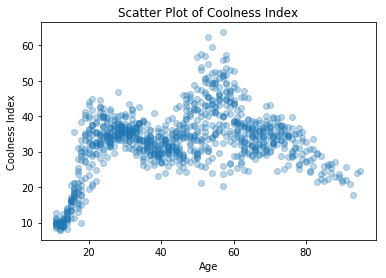

In [16]:
plt.scatter(x =df1['Age'], y =df1['Cool'], alpha=0.3, label="Points")
plt.title('Scatter Plot of Coolness Index')
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.show()

(b)

In [17]:
df1["G1"] = np.where((df1['Age'] >= 11) & (df1['Age'] < 22),1,0)
df1["G2"] = np.where((df1['Age'] >= 22) & (df1['Age'] < 40),1,0)
df1["G3"] = np.where((df1['Age'] >= 40) & (df1['Age'] < 59),1,0)
df1["G4"] = np.where((df1['Age'] >= 59) & (df1['Age'] < 77),1,0)
df1["G5"] = np.where((df1['Age'] >= 77) & (df1['Age'] <= 95),1,0)

In [18]:
X=df1[["G1","G2","G3","G4","G5"]]
reg=sm.OLS(df1['Cool'], X, missing='drop').fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                   Cool   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Wed, 27 Feb 2019   Prob (F-statistic):          3.73e-114
Time:                        10:50:59   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G1            20.1025      0.562     35.746      0.0

In [19]:
for i in range(5):
    print("Beta_{} = {}".format(i+1, reg.params[i]))

Beta_1 = 20.102457252090748
Beta_2 = 34.47578807755938
Beta_3 = 37.63510549244961
Beta_4 = 35.22540004024275
Beta_5 = 27.296378244321282


In [20]:
print('The predicted coolness of a 73-year old from the stepwise function is', reg.params[3])

The predicted coolness of a 73-year old from the stepwise function is 35.22540004024275


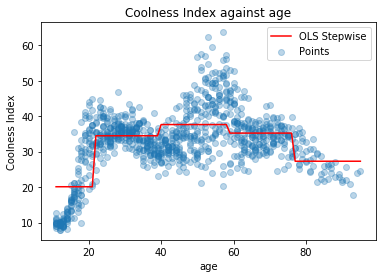

In [21]:
plt.scatter(df1['Age'], df1['Cool'], alpha=0.3, label="Points")
plt.plot(df1['Age'], reg.predict(), 'r', label = "OLS Stepwise")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

(c)

In [22]:
df2=df1.groupby('Age').mean()
df2['Age']=df2.index
df2.head()

,Cool,G1,G2,G3,G4,G5,Age
Age,,,,,,,
11.0,10.110237,1,0,0,0,0,11.0
12.0,9.365623,1,0,0,0,0,12.0
13.0,10.015882,1,0,0,0,0,13.0
14.0,11.747109,1,0,0,0,0,14.0
15.0,15.434739,1,0,0,0,0,15.0


In [23]:
knots=[22, 40, 59, 77]
linear_spline=LSQUnivariateSpline(df2.Age.values, df2.Cool.values, t=knots, k=1)

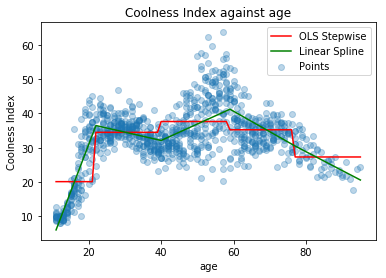

In [24]:
plt.scatter(df1.Age, df1.Cool, alpha=0.3, label="Points")
plt.plot(df1.Age, reg.predict(), "r", label = "OLS Stepwise")
plt.plot(df2.Age, linear_spline(df2.Age), "g", label = "Linear Spline")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()


In [25]:
print('The predicted coolness of a 73-year old from the linear spline is', linear_spline(73))

The predicted coolness of a 73-year old from the linear spline is 32.86784862349653


(d)

In [26]:
cubic_spline = LSQUnivariateSpline(df2.Age.values, df2.Cool.values, knots, k=3)

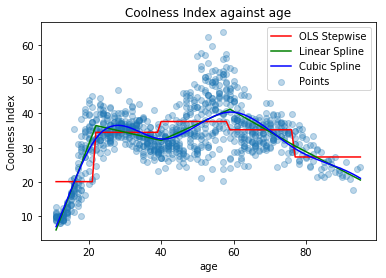

In [27]:
plt.scatter(df1.Age, df1.Cool, alpha=0.3, label="Points")
plt.plot(df1.Age, reg.predict(), "r", label = "OLS Stepwise")
plt.plot(df2.Age, linear_spline(df2.Age), "g", label = "Linear Spline")
plt.plot(df2.Age, cubic_spline(df2.Age), "b", label = "Cubic Spline")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()

In [28]:
print('The predicted coolness of a 73-year old from the cubic spline is', cubic_spline(73))

The predicted coolness of a 73-year old from the cubic spline is 32.642301066279764
